<a href="https://colab.research.google.com/github/Beatoy/INTELIGENCIA-ARTIFICIAL/blob/main/RNN/BITCOIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Celda 1 - CARGA DE DATOS
import pandas as pd
url = "https://gist.githubusercontent.com/mevangelista-alvarado/6f4f28c00f9e683108637cb3c8d5db89/raw/1ce753283fce23eeab952fa1d660a7069bbe9104/Bitcoin_1_1_2024-6_9_2024_historical_data_coinmarketcap.csv"
df_raw = pd.read_csv(url, sep=';')
df_raw = df_raw.sort_values('timeOpen').reset_index(drop=True)
print("Datos cargados correctamente!")
df_raw.head()

Datos cargados correctamente!


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-01-03T00:00:00.000Z,2024-01-03T23:59:59.999Z,2024-01-03T09:40:00.000Z,2024-01-03T12:10:00.000Z,2781,44961.603187,45503.241795,40813.534868,42848.175641,4.634232e+10,8.393459e+11,2024-01-03T23:59:59.999Z
1,2024-01-04T00:00:00.000Z,2024-01-04T23:59:59.999Z,2024-01-04T22:22:00.000Z,2024-01-04T01:26:00.000Z,2781,42855.814761,44770.023414,42675.174007,44179.921701,3.044809e+10,8.654825e+11,2024-01-04T23:59:59.999Z
2,2024-01-05T00:00:00.000Z,2024-01-05T23:59:59.999Z,2024-01-05T23:07:00.000Z,2024-01-05T01:49:00.000Z,2781,44192.978699,44353.285859,42784.718266,44162.691630,3.233603e+10,8.651827e+11,2024-01-05T23:59:59.999Z
3,2024-01-06T00:00:00.000Z,2024-01-06T23:59:59.999Z,2024-01-06T00:10:00.000Z,2024-01-06T07:07:00.000Z,2781,44178.954607,44227.631307,43475.156431,43989.194093,1.609250e+10,8.618220e+11,2024-01-06T23:59:59.999Z
4,2024-01-07T00:00:00.000Z,2024-01-07T23:59:59.999Z,2024-01-07T14:09:00.000Z,2024-01-07T23:45:00.000Z,2781,43998.464243,44495.571471,43662.228627,43943.097229,1.933057e+10,8.609518e+11,2024-01-07T23:59:59.999Z


In [ ]:
# Celda 2 - SELECCIÓN Y PREPROCESAMIENTO (MinMaxScaler 0-1 sobre open,high,low,close,volume)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

features = ['open', 'high', 'low', 'close', 'volume']
df = df_raw[features].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

print(f"Features usadas: {features}")
print(f"Shape datos escalados: {scaled_data.shape}")


Features usadas: ['open', 'high', 'low', 'close', 'volume']
Shape datos escalados: (159, 5)


In [ ]:
# Celda 3 - CREAR SECUENCIAS (ventana de 60 días -> X: (muestras,60,5), y: close del día siguiente)
window_size = 60
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 3])  # close = columna 3 en features ['open','high','low','close','volume']
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size)
print(f"Secuencias creadas → X: {X.shape}, y: {y.shape}")


Secuencias creadas → X: (99, 60, 5), y: (99,)


In [ ]:
# Celda 4 - DIVISIÓN TRAIN / TEST (80% train, 20% test, corte secuencial, NO shuffle)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train: {len(X_train)} muestras | Test: {len(X_test)} muestras")


Train: 79 muestras | Test: 20 muestras


In [ ]:
# Celda 5 - MODELO LSTM (3 capas LSTM + Dropout + Dense final)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,301 (813.68 KB)

 Trainable params: 208,301 (813.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Celda 6 - ENTRENAMIENTO (epochs=40, batch_size=32, validation_split=0.1)
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - loss: 0.5788 - val_loss: 0.2726
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2414 - val_loss: 0.0079
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0557 - val_loss: 0.0674
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0998 - val_loss: 0.0096
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0318 - val_loss: 0.0412
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0458 - val_loss: 0.0330
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0418 - val_loss: 0.0102
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0200 - val_loss: 0.0094
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0348 - val_loss: 0.0112
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0291 - val_loss: 0.0071
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0171 - val_loss: 0.0104
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0223 - val_lo

In [ ]:
# Celda 7 - PREDICCIONES EN TEST (desescalado correcto solo para la columna 'close')
import numpy as np

predictions_scaled = model.predict(X_test)          # predicciones en escala 0-1 (solo close)
# reconstruir array con todas las features para usar inverse_transform del scaler
pred_full = np.zeros((len(predictions_scaled), len(features)))
pred_full[:, 3] = predictions_scaled.flatten()     # colocar predicción en columna 3 (close)
predictions = scaler.inverse_transform(pred_full)[:, 3]  # desescalar y tomar solo close

# desescalar y_test (que está en escala 0-1) para obtener precios reales
y_test_full = np.zeros((len(y_test), len(features)))
y_test_full[:, 3] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, 3]

print("Predicciones en test generadas y desescaladas")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Predicciones en test generadas y desescaladas


In [ ]:
# Celda 8 - MÉTRICAS REALES (MAE, RMSE, MAPE)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test_inv, predictions)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
mape = mean_absolute_percentage_error(y_test_inv, predictions) * 100

print(f"MAE:  {mae:.2f} USD")
print(f"RMSE: {rmse:.2f} USD")
print(f"MAPE: {mape:.2f}%")


MAE:  4581.11 USD
RMSE: 4745.45 USD
MAPE: 6.62%


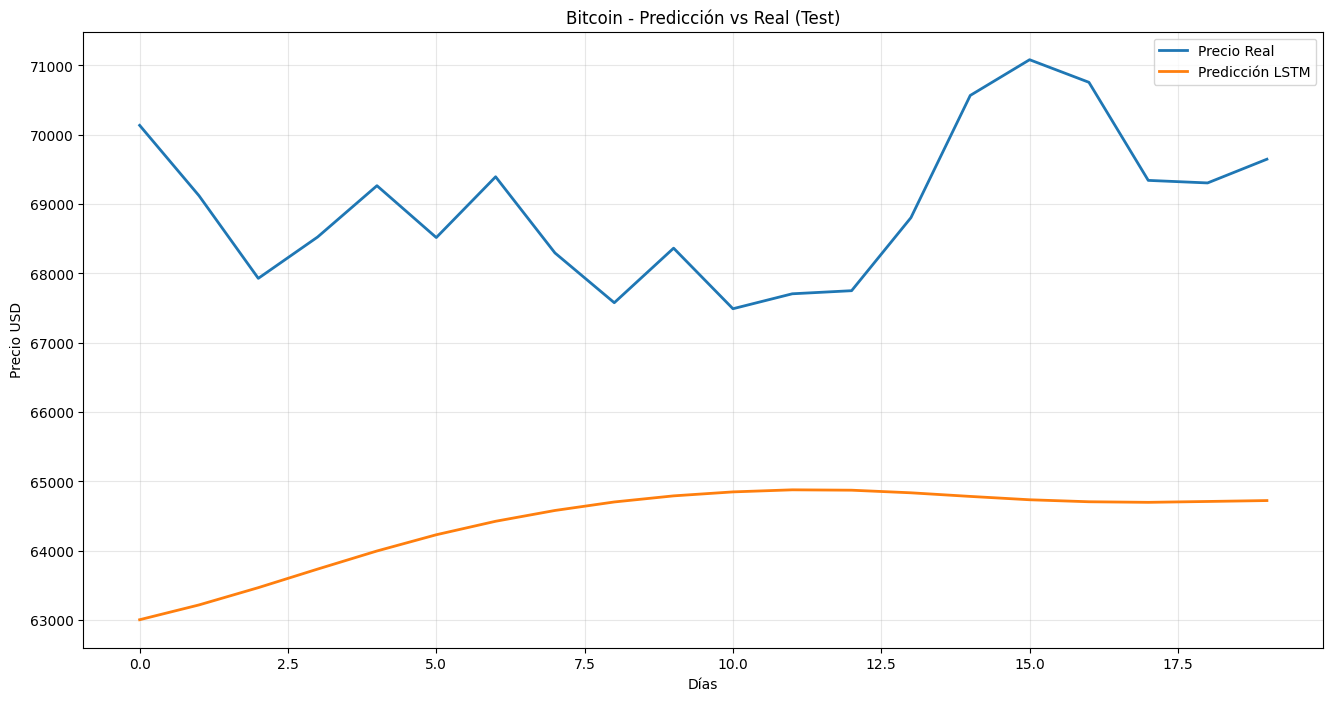

In [ ]:
# Celda 9 - GRÁFICO: Predicción vs Real en período de prueba
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(16,8))
plt.plot(y_test_inv, label='Precio Real', linewidth=2)
plt.plot(predictions, label='Predicción LSTM', linewidth=2)
plt.title('Bitcoin - Predicción vs Real (Test)')
plt.xlabel('Días')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Celda 10 - PREDICCIÓN FUTURA AUTOREGRESIVA (30 días)
days_to_predict = 30
future_predictions = []
current_batch = scaled_data[-window_size:].reshape((1, window_size, len(features)))

for i in range(days_to_predict):
    next_pred = model.predict(current_batch, verbose=0)   # devuelve valor escalado (close)
    future_predictions.append(next_pred[0,0])

    # construir nueva fila escalada para desplazar la ventana (solo close tiene valor; otras features 0)
    new_row = np.zeros((1, 1, len(features)))
    new_row[0,0,3] = next_pred[0,0]   # colocamos la predicción escalada en la columna 'close'
    current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)

# desescalar predicciones futuras
future_full = np.zeros((len(future_predictions), len(features)))
future_full[:, 3] = future_predictions
future_pred_inv = scaler.inverse_transform(future_full)[:, 3]

print("Predicción futura (30 días) generada")


Predicción futura (30 días) generada


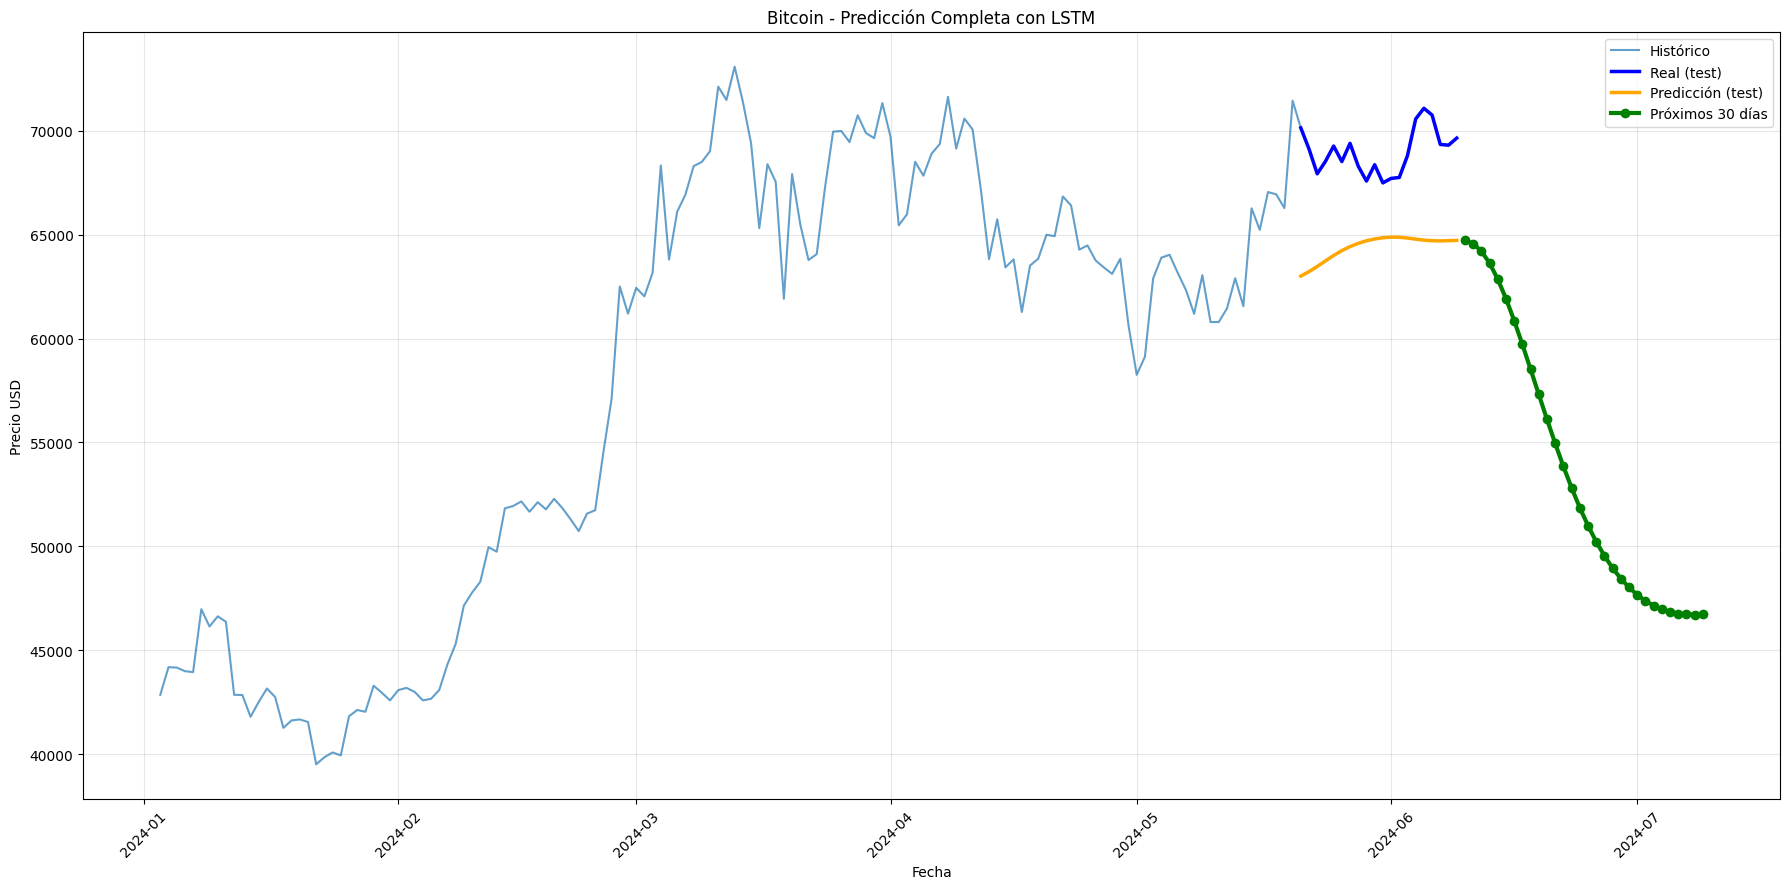


Predicción Bitcoin en 30 días → $46,728 USD


In [ ]:
# Celda 11 - GRÁFICO FINAL COMPLETO (histórico + test + próximos 30 días) y print de último valor
import matplotlib.pyplot as plt
import pandas as pd

# fechas para test y futuro
last_dates = pd.to_datetime(df_raw['timeOpen'].iloc[-len(y_test_inv):])
future_dates = pd.date_range(start=last_dates.iloc[-1] + pd.Timedelta(days=1), periods=days_to_predict)

plt.figure(figsize=(18,9))
plt.plot(pd.to_datetime(df_raw['timeOpen']), df_raw['close'], label='Histórico', alpha=0.7)
plt.plot(last_dates, y_test_inv, label='Real (test)', color='blue', linewidth=2.5)
plt.plot(last_dates, predictions, label='Predicción (test)', color='orange', linewidth=2.5)
plt.plot(future_dates, future_pred_inv, label='Próximos 30 días', color='green', linewidth=3, marker='o')

plt.title('Bitcoin - Predicción Completa con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nPredicción Bitcoin en 30 días → ${future_pred_inv[-1]:,.0f} USD")
